In [2]:
import os, shutil, glob
import urllib.request as r
import torch, timm, tqdm
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torch import nn


In [3]:
#CONSONANT VARIABLES
SAVE_DIR, SAVE_PREFIX = "data/saved_models", "apple_disease" #for model saving 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] #ImagaNet values

# 1 Data preparation

In [4]:

# a)datasetni yuklab olish
def download_dataset(path_to_download, dataset_name = "apple_disease"): 
    
    dataset_names = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", 
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac", "apple_disease"]
    
    assert dataset_name in dataset_names, f"Mavjud bo'lgan dataset {dataset_names} dan birini kiriting!"
    if dataset_name == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    if dataset_name == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif dataset_name == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif dataset_name == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif dataset_name == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif dataset_name == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif dataset_name == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif dataset_name == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
    
    # Check if is already exist 
    if os.path.isfile(f"{path_to_download}/{dataset_name}.csv") or os.path.isdir(f"{path_to_download}/{dataset_name}"): 
        print(f"Dataset allaqachon yuklab olingan. {path_to_download}/{dataset_name} papkasini ni tekshiring."); 

    # If data doesn't exist in particular folder
    else: 
        ds_name = url.split("/")[-1] 
        # Download the dataset
        print(f"{ds_name} yuklanmoqda...")
        os.system(f"{url} -p {path_to_download}")
        shutil.unpack_archive(f"{path_to_download}/{ds_name}.zip", extract_dir=f"{path_to_download}/{dataset_name}")
        os.remove(f"{path_to_download}/{ds_name}.zip")
        print(f"Tanlangan dataset {path_to_download}/{dataset_name} papkasiga yuklab olindi!")
    
    return f"{path_to_download}/{dataset_name}"
    
dataset_path = download_dataset(path_to_download = "data", dataset_name = "apple_disease")
print(dataset_path)


apple-disease-dataset yuklanmoqda...
Tanlangan dataset data/apple_disease papkasiga yuklab olindi!
data/apple_disease


In [9]:
# b) Dataset binary yoki multiclass dataset ekanligini aniqlang;
# c) Har bir datasetdagi datani olib kelish uchun CustomDataset class ni yozing: har birdatadan 2ta o’zgaruvchi qaytishi kerak,
# birinchisi input rasm (tensor), ikkinchisi output javob (raqam ya’ni class, int);

#make a Custom dataset class 
class AppleDisease(Dataset): 
    def __init__(self, dataset_path, transformations = None):
        super().__init__()
        self.image_paths = glob.glob(f"{dataset_path}/*/images/*")
        self.transformations = transformations
        self.class_names = {} #dict for storing labels 
        class_value = 0
        
        for i, img_path in enumerate(self.image_paths): 
            class_n = self.get_class_name(img_path)
            #print(class_n)
            if class_n not in self.class_names: self.class_names[class_n] = class_value; class_value +=1

    def get_class_name(self, img_path): 
        #path only for apple disease dataset
        return img_path.split(".")[0].split("\\")[-1].split("_")[0]
        
    def __len__(self): 
        return len(self.image_paths)

    def __getitem__(self, index): 
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert('RGB')
        label = self.class_names[self.get_class_name(img_path)] # get ground truth

        if self.transformations is not None: 
            image = self.transformations(image)

        return image, label 


#Data Transformation for Custom dataset Class
#T.Normalize(std=[0.485, 0.456, 0.406], mean=[0.229, 0.224, 0.225])
tfs = T.Compose([T.Resize((224,224)), T.ToTensor(),T.Normalize(std=STD, mean=MEAN)])   
apple_disease_ds = AppleDisease(dataset_path=dataset_path, transformations=tfs)
class_names = list(apple_disease_ds.class_names.keys())

#Save class names 
import pickle as p
if  os.path.isdir(f"{SAVE_DIR}/{SAVE_PREFIX}"):
    with open(f'{SAVE_DIR}/{SAVE_PREFIX}_classnames.pickle', 'wb') as f: p.dump(class_names, f, protocol=p.HIGHEST_PROTOCOL)
else:
    os.makedirs(f"{SAVE_DIR}")
    with open(f'{SAVE_DIR}/{SAVE_PREFIX}_classnames.pickle', 'wb') as f: p.dump(class_names, f, protocol=p.HIGHEST_PROTOCOL)


print(len(apple_disease_ds))
print(apple_disease_ds.class_names)

print(class_names)

11297
{'AlternariaBoltch': 0, 'BlackRot': 1, 'CedarAppleRust': 2, 'Rust': 3, 'scab': 4}
['AlternariaBoltch', 'BlackRot', 'CedarAppleRust', 'Rust', 'scab']


In [10]:
###Check whether balance or imbalance status of dataset
class_list = []

for idx, img_path in enumerate(glob.glob(f"{dataset_path}/*/images/*")): 

    class_name = img_path.split(".")[0].split("\\")[-1].split("_")[0]
    class_list.append(class_name)
    
classes, counts = np.unique(class_list, return_counts=True)
print(f"Datasetdagi malumotlar taqsimoti:")
for el, c in zip(classes,counts):
    
    print(f"{el}:{c}")



Datasetdagi malumotlar taqsimoti:
AlternariaBoltch:1820
BlackRot:2119
CedarAppleRust:1274
Rust:4056
scab:2028


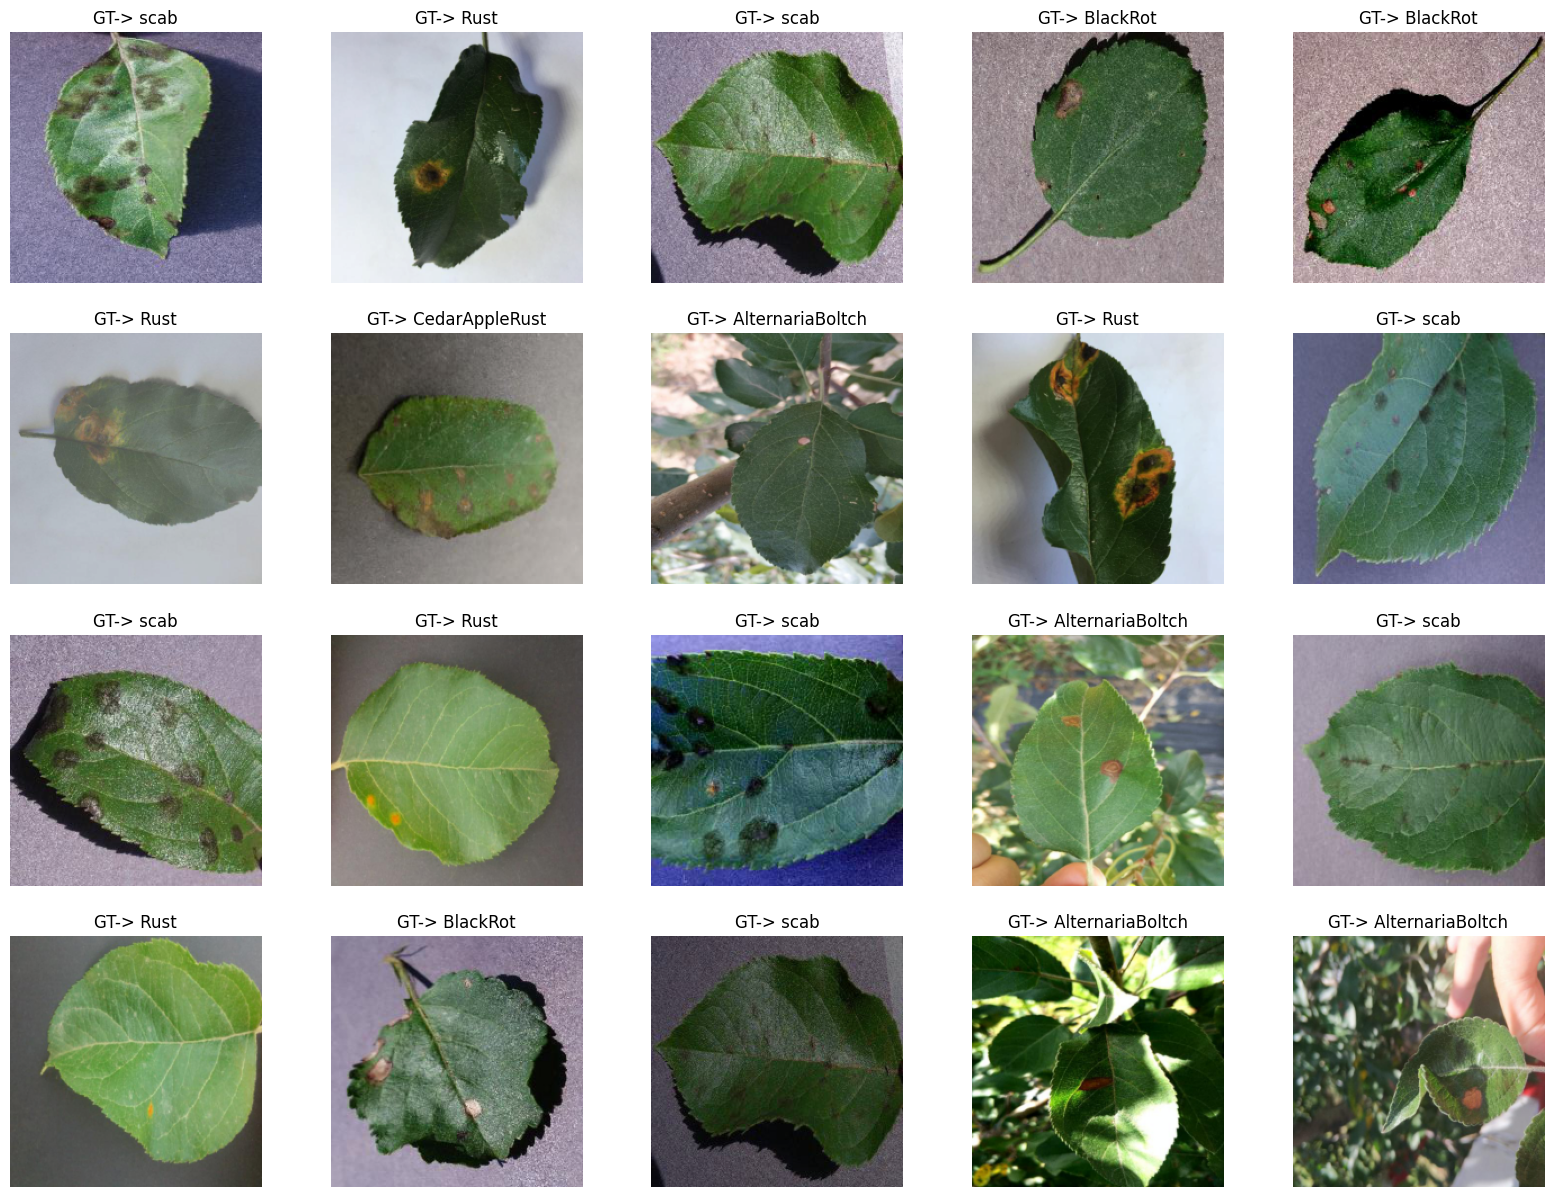

In [11]:
#d) 
#Datasetdagi rasm va mos javob (int) larni chizib ko’rsatadigan visualization kodni yozing: 
#plt.imshow yordamida rasmni chizib, plt.title yordamida rasmning qaysi klassga tegishliligini yozib, ko’rsating. 
#Quyidagicha chiqara olgan talabaga bonus ball beriladi

##See examples from data 
plt.figure(figsize=(20,15))
for i in range(20):
    random_index = np.random.randint(1, len(apple_disease_ds))
    tensor_img, label = apple_disease_ds[random_index] #get random index image and label from dataset
    # np_image = ((tensor_img)*255).cpu().permute(1,2,0).numpy().astype("uint8")

    np_image = np.transpose(tensor_img.detach().cpu().numpy())
    np_image = np_image * STD + MEAN
    np_image = np.clip(np_image, 0, 1) * 255  # Clip values to 0-1 and scale to 0-255
    np_image = np_image.astype(np.uint8)  # Convert to uint8 for integer representation
    
    plt.subplot(4,5,i+1)
    plt.axis("off")
    plt.title(f'GT-> {class_names[label]}')
    plt.imshow(np_image, cmap='gray')


In [12]:
# e) Datasetni train, validation, va test setlariga ajratib, train, validation, va test dataloaderlarni yarating;
from torch.utils.data import random_split

train_data, valid_data, test_data  = random_split(dataset = apple_disease_ds, 
                                               lengths = [0.8, 0.1, 0.1], 
                                               generator = torch.Generator().manual_seed(13)) #80% for training....

print(f"Train data size:{len(train_data)}   |  Valid data size:{len(valid_data)}    |    Test data size: {len(test_data)}")

bs = 32
train_dataloader = DataLoader(dataset = train_data, batch_size=bs, shuffle=True,)
valid_dataloader = DataLoader(dataset = valid_data, batch_size=bs,shuffle=False, )
test_dataloader = DataLoader(dataset = test_data, batch_size=1,  shuffle=False, )

dataiter = iter(train_dataloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)
 

Train data size:9038   |  Valid data size:1130    |    Test data size: 1129
torch.Size([32, 3, 224, 224])
torch.Size([32])


# 2-Build a model

In [13]:
#model config 
model = timm.create_model(model_name='resnet50', pretrained=True, num_classes=len(class_names))
model = model.to(DEVICE)
learnig_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learnig_rate)

def train(epoch, train_dataloader, criterion, optimizer):
    model.train()
    
    loss_per_batch = []
    total_acc = 0
    
    print(f"{epoch+1} - Training started ...".upper())
    for images, labels in tqdm.tqdm(train_dataloader):

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        #predict 
        prediction = model(images)
        preds = torch.argmax(prediction, dim=1)
        acc_per_batch = (preds == labels).sum().item()
        total_acc += acc_per_batch #add each batch acc
        
        loss = criterion(prediction, labels)
        loss_per_batch.append(loss.item()) # add each loss of batch 
        optimizer.zero_grad()
        #loss and update weights 
        loss.backward()
        optimizer.step()
        
    epoch_loss = np.mean(loss_per_batch) #1 ta epochdagi (400) ta batchni loss larini qoshib mean oladi 
    average_acc = total_acc / len(train_dataloader.dataset)
 
    print(f"Epoch - {epoch+1} ||||| Loss: {epoch_loss:.3f} |||| Accuracy: {average_acc:.3f}")
    print('Training finished !!!!!!!! \n')

    return [average_acc, epoch_loss] #average acc and loss 
    

def validation(epoch, valid_dataloader, criterion): 
    model.eval()
   
    print(f"{epoch+1} - Validation started.....".upper())
    
    loss_per_batch = []
    total_acc = 0
    
    with torch.no_grad():
        for images, labels in tqdm.tqdm(valid_dataloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            #predict 
            prediction = model(images)
            preds = torch.argmax(prediction, dim=1)
            acc_per_batch = (preds== labels).sum().item()
            total_acc += acc_per_batch #add each batch accuracy

            loss = criterion(prediction, labels)
            loss_per_batch.append(loss.item()) #Add each batch loss to one list 
        
        epoch_loss = np.mean(loss_per_batch)  #1 ta epochdagi barcha batchni loss larini qoshib mean oladi 
        average_acc = total_acc / len(valid_dataloader.dataset)
        
        print(f"Epoch - {epoch+1} ||||| Loss: {epoch_loss:.3f} |||| Accuracy: {average_acc:.3f}")
        
    print('Validation finished !!!!!!!!\n')   

    return [average_acc, epoch_loss] #average acc and loss 
        
#lss = 0
acc = 0   
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(10):

    train_acc, train_loss = train(epoch,  train_dataloader, criterion, optimizer)
    val_acc, val_loss = validation(epoch, valid_dataloader, criterion)
    
    #Get metrics for plotting 
    train_acc_list.append(train_acc) #list adds train acc result per epoch
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    #Save best model according to accuracy
    if val_acc > acc: 
        os.makedirs(SAVE_DIR, exist_ok = True)
        acc = val_acc
        best_model = model.state_dict() #whole status of model in dict
        torch.save(best_model, f"{SAVE_DIR}/{SAVE_PREFIX}_best_model.pth")

    # # #Save modell according to min LOSS
    # if val_loss > lss: 
    #     os.makedirs(SAVE_DIR, exist_ok = True)
    #     lss = val_loss
    #     best_model = model.state_dict() #whole status of model in dict
    #     torch.save(best_model, f"{SAVE_DIR}/{SAVE_PREFIX}_best_model.pth")



1 - TRAINING STARTED ...


100%|██████████| 283/283 [01:28<00:00,  3.19it/s]


Epoch - 1 ||||| Loss: 0.179 |||| Accuracy: 0.932
Training finished !!!!!!!! 

1 - VALIDATION STARTED.....


100%|██████████| 36/36 [00:10<00:00,  3.35it/s]


Epoch - 1 ||||| Loss: 0.047 |||| Accuracy: 0.986
Validation finished !!!!!!!!

2 - TRAINING STARTED ...


100%|██████████| 283/283 [00:53<00:00,  5.31it/s]


Epoch - 2 ||||| Loss: 0.053 |||| Accuracy: 0.980
Training finished !!!!!!!! 

2 - VALIDATION STARTED.....


100%|██████████| 36/36 [00:05<00:00,  6.43it/s]


Epoch - 2 ||||| Loss: 0.043 |||| Accuracy: 0.982
Validation finished !!!!!!!!

3 - TRAINING STARTED ...


100%|██████████| 283/283 [00:56<00:00,  5.05it/s]


Epoch - 3 ||||| Loss: 0.033 |||| Accuracy: 0.987
Training finished !!!!!!!! 

3 - VALIDATION STARTED.....


100%|██████████| 36/36 [00:06<00:00,  5.69it/s]


Epoch - 3 ||||| Loss: 0.036 |||| Accuracy: 0.981
Validation finished !!!!!!!!

4 - TRAINING STARTED ...


100%|██████████| 283/283 [00:52<00:00,  5.40it/s]


Epoch - 4 ||||| Loss: 0.028 |||| Accuracy: 0.987
Training finished !!!!!!!! 

4 - VALIDATION STARTED.....


100%|██████████| 36/36 [00:05<00:00,  6.43it/s]


Epoch - 4 ||||| Loss: 0.052 |||| Accuracy: 0.979
Validation finished !!!!!!!!

5 - TRAINING STARTED ...


100%|██████████| 283/283 [00:53<00:00,  5.27it/s]


Epoch - 5 ||||| Loss: 0.023 |||| Accuracy: 0.987
Training finished !!!!!!!! 

5 - VALIDATION STARTED.....


100%|██████████| 36/36 [00:06<00:00,  5.60it/s]


Epoch - 5 ||||| Loss: 0.033 |||| Accuracy: 0.985
Validation finished !!!!!!!!

6 - TRAINING STARTED ...


100%|██████████| 283/283 [00:53<00:00,  5.29it/s]


Epoch - 6 ||||| Loss: 0.038 |||| Accuracy: 0.984
Training finished !!!!!!!! 

6 - VALIDATION STARTED.....


100%|██████████| 36/36 [00:06<00:00,  5.92it/s]


Epoch - 6 ||||| Loss: 0.037 |||| Accuracy: 0.987
Validation finished !!!!!!!!

7 - TRAINING STARTED ...


100%|██████████| 283/283 [00:55<00:00,  5.13it/s]


Epoch - 7 ||||| Loss: 0.029 |||| Accuracy: 0.986
Training finished !!!!!!!! 

7 - VALIDATION STARTED.....


100%|██████████| 36/36 [00:06<00:00,  5.91it/s]


Epoch - 7 ||||| Loss: 0.025 |||| Accuracy: 0.984
Validation finished !!!!!!!!

8 - TRAINING STARTED ...


100%|██████████| 283/283 [00:54<00:00,  5.20it/s]


Epoch - 8 ||||| Loss: 0.022 |||| Accuracy: 0.988
Training finished !!!!!!!! 

8 - VALIDATION STARTED.....


100%|██████████| 36/36 [00:06<00:00,  5.90it/s]


Epoch - 8 ||||| Loss: 0.044 |||| Accuracy: 0.981
Validation finished !!!!!!!!

9 - TRAINING STARTED ...


100%|██████████| 283/283 [00:56<00:00,  5.02it/s]


Epoch - 9 ||||| Loss: 0.025 |||| Accuracy: 0.986
Training finished !!!!!!!! 

9 - VALIDATION STARTED.....


100%|██████████| 36/36 [00:07<00:00,  5.04it/s]


Epoch - 9 ||||| Loss: 0.033 |||| Accuracy: 0.988
Validation finished !!!!!!!!

10 - TRAINING STARTED ...


100%|██████████| 283/283 [00:59<00:00,  4.72it/s]


Epoch - 10 ||||| Loss: 0.022 |||| Accuracy: 0.987
Training finished !!!!!!!! 

10 - VALIDATION STARTED.....


100%|██████████| 36/36 [00:06<00:00,  5.42it/s]

Epoch - 10 ||||| Loss: 0.037 |||| Accuracy: 0.984
Validation finished !!!!!!!!



# 3 Visualization

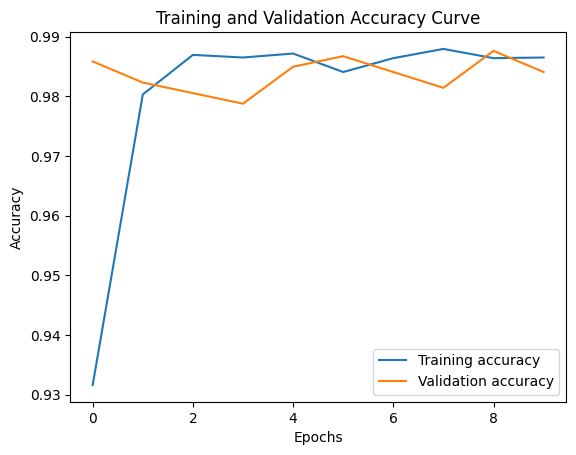

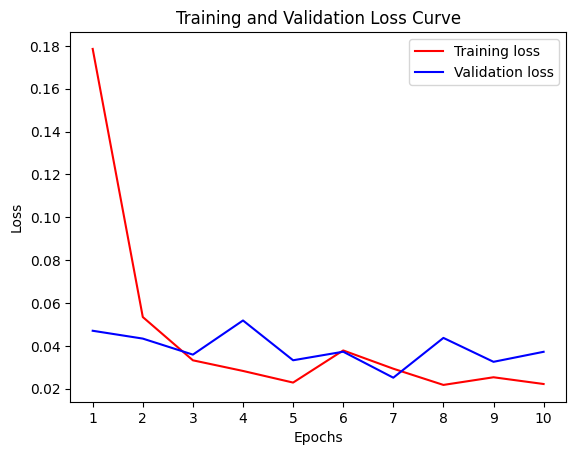

In [15]:
# Plot the training acc curve
plt.plot(train_acc_list, label='Training accuracy')
plt.plot(val_acc_list, label="Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve')
plt.legend()
plt.show()

# Plot the training acc curve
plt.plot(train_loss_list, label='Training loss', c = 'red')
plt.plot(val_loss_list, label="Validation loss", c='b')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.xticks(ticks=np.arange(len(train_loss_list)), labels=[i for i in range(1, len(train_loss_list)+1)])
plt.legend(); plt.show()

# 4 Inference part 

[0, 1, 2, 0, 3, 3, 1, 4, 0, 3, 1, 3, 0, 1, 4, 0, 2, 3, 1, 1, 0, 4, 1, 3, 0, 3, 1, 4, 1, 3, 0, 1, 3, 0, 4, 3, 3, 1, 4, 1, 0, 3, 3, 3, 1, 3, 0, 1, 3, 0, 3, 1, 2, 2, 1, 4, 3, 3, 1, 4, 4, 3, 4, 4, 3, 3, 3, 2, 3, 3, 4, 1, 4, 2, 4, 3, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3, 3, 3, 4, 3, 2, 1, 0, 4, 1, 0, 2, 3, 0, 3, 4, 3, 0, 4, 1, 4, 3, 3, 3, 3, 3, 1, 3, 1, 2, 3, 2, 3, 2, 4, 3, 3, 0, 3, 3, 1, 4, 1, 2, 0, 4, 3, 4, 0, 3, 4, 3, 3, 3, 3, 3, 1, 2, 3, 2, 3, 3, 2, 4, 1, 4, 0, 0, 4, 3, 3, 3, 3, 3, 4, 1, 4, 3, 4, 4, 0, 0, 2, 1, 2, 0, 3, 1, 3, 3, 3, 0, 1, 0, 3, 3, 4, 0, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 1, 3, 2, 2, 3, 4, 0, 3, 1, 3, 4, 0, 3, 0, 4, 4, 1, 3, 3, 4, 4, 0, 3, 1, 0, 1, 3, 0, 1, 4, 4, 4, 1, 2, 1, 3, 3, 4, 3, 4, 0, 3, 0, 4, 1, 2, 3, 3, 3, 2, 2, 4, 3, 0, 3, 3, 4, 0, 4, 3, 2, 3, 3, 3, 3, 3, 1, 2, 3, 1, 3, 0, 3, 4, 4, 0, 3, 3, 3, 0, 1, 3, 3, 0, 1, 2, 1, 3, 3, 0, 2, 3, 1, 1, 3, 2, 1, 3, 3, 1, 0, 4, 2, 0, 1, 0, 1, 3, 4, 2, 1, 0, 2, 2, 1, 0, 4, 3, 0, 3, 3, 3, 0, 3, 0, 0, 3, 4, 2, 1, 0, 2, 3, 0, 3, 0, 0, 

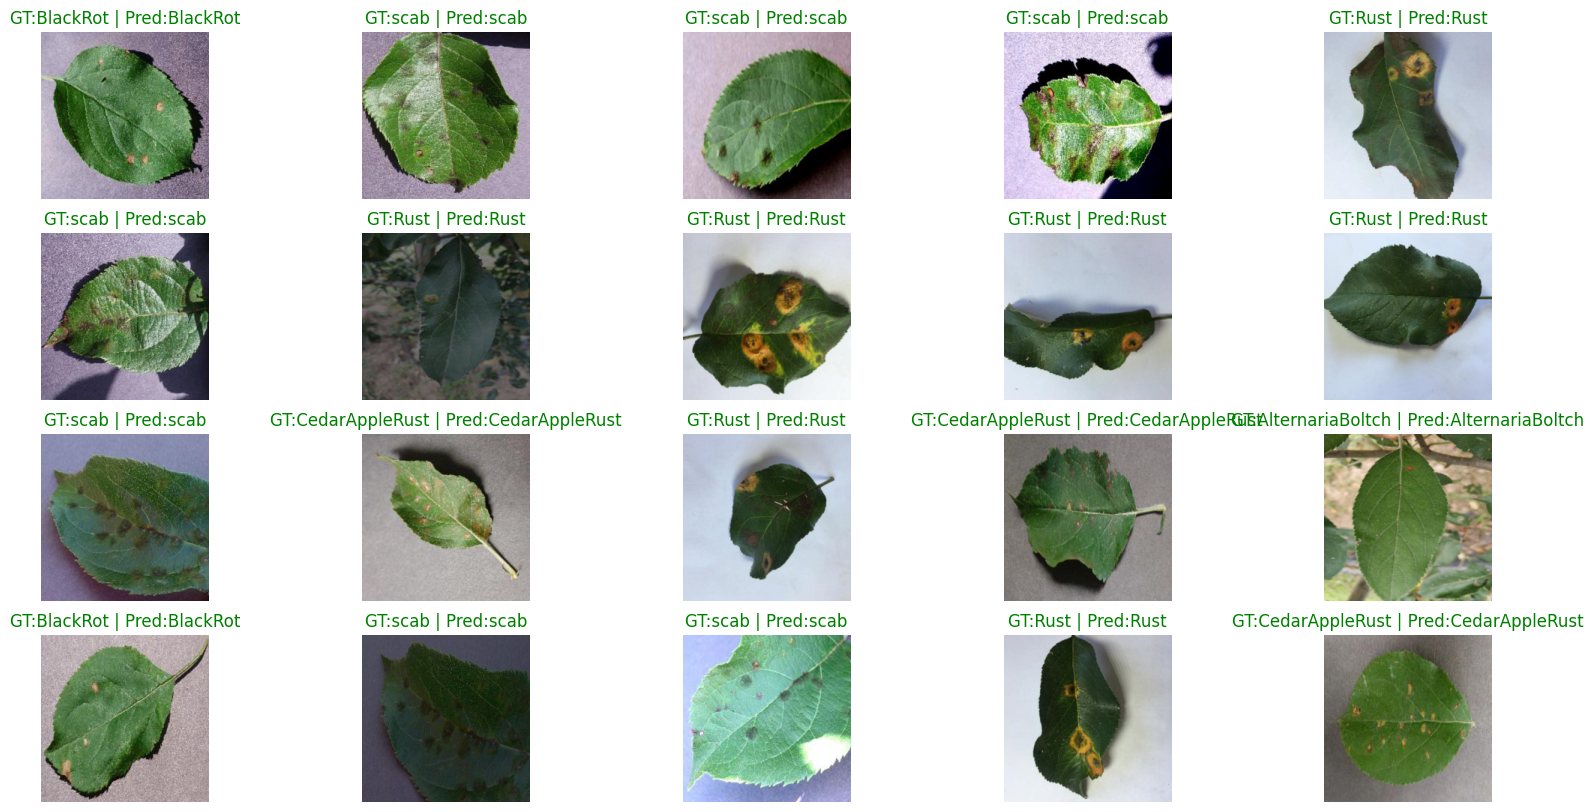

In [16]:
from matplotlib import pyplot as plt 
import random

#store values for plotting
haqiqiy_list = []
bashorat_list = []
rasmlar_list = []

#Prediction values after prediction
for (img, lb) in [batch for batch in test_dataloader]: 
    img = img.to(DEVICE)
    lb = lb.to(DEVICE)
    bashorat = model(img) 
    prediction = torch.argmax(bashorat,dim=1)

    haqiqiy_list.append(lb.item())
    bashorat_list.append(prediction.item())
    rasmlar_list.append(torch.squeeze(img.to('cpu')))
    

print(haqiqiy_list)
print(bashorat_list)
togri = np.count_nonzero(np.equal(haqiqiy_list, bashorat_list))
print(f"{len(test_dataloader.dataset)} dan {togri} ta to'gri bashorat qilgan. {(togri*100) / len(test_dataloader.dataset):.2f} %")


random_indexs = [random.randint(0, len(haqiqiy_list) - 1) for _ in range(20)]
plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indexs): 
    plt.subplot(4, 5, i+1) 
    tensor_img = rasmlar_list[idx]
    np_image = np.transpose(tensor_img.detach().cpu().numpy())
    np_image = np_image * STD + MEAN
    np_image = np.clip(np_image, 0, 1) * 255  # Clip values to 0-1 and scale to 0-255
    final_img = np_image.astype(np.uint8)  # Convert to uint8 for integer representation

    # final_img = (rasmlar_list[idx].permute(1,2,0).numpy()*255).astype('uint8') #tensor to numpy 
    plt.axis("off")
    equal = class_names[haqiqiy_list[idx]] = class_names[bashorat_list[idx]]
    color = ('green' if equal else 'red')
    plt.title(f"GT:{class_names[haqiqiy_list[idx]]} | Pred:{class_names[bashorat_list[idx]]}", color=color)
    plt.xlabel('ab')
    plt.imshow(final_img)

# GRAD CAM INFERENCE


1129 rasm test qilinganda 99.11 % foiz aniqlikda topdi


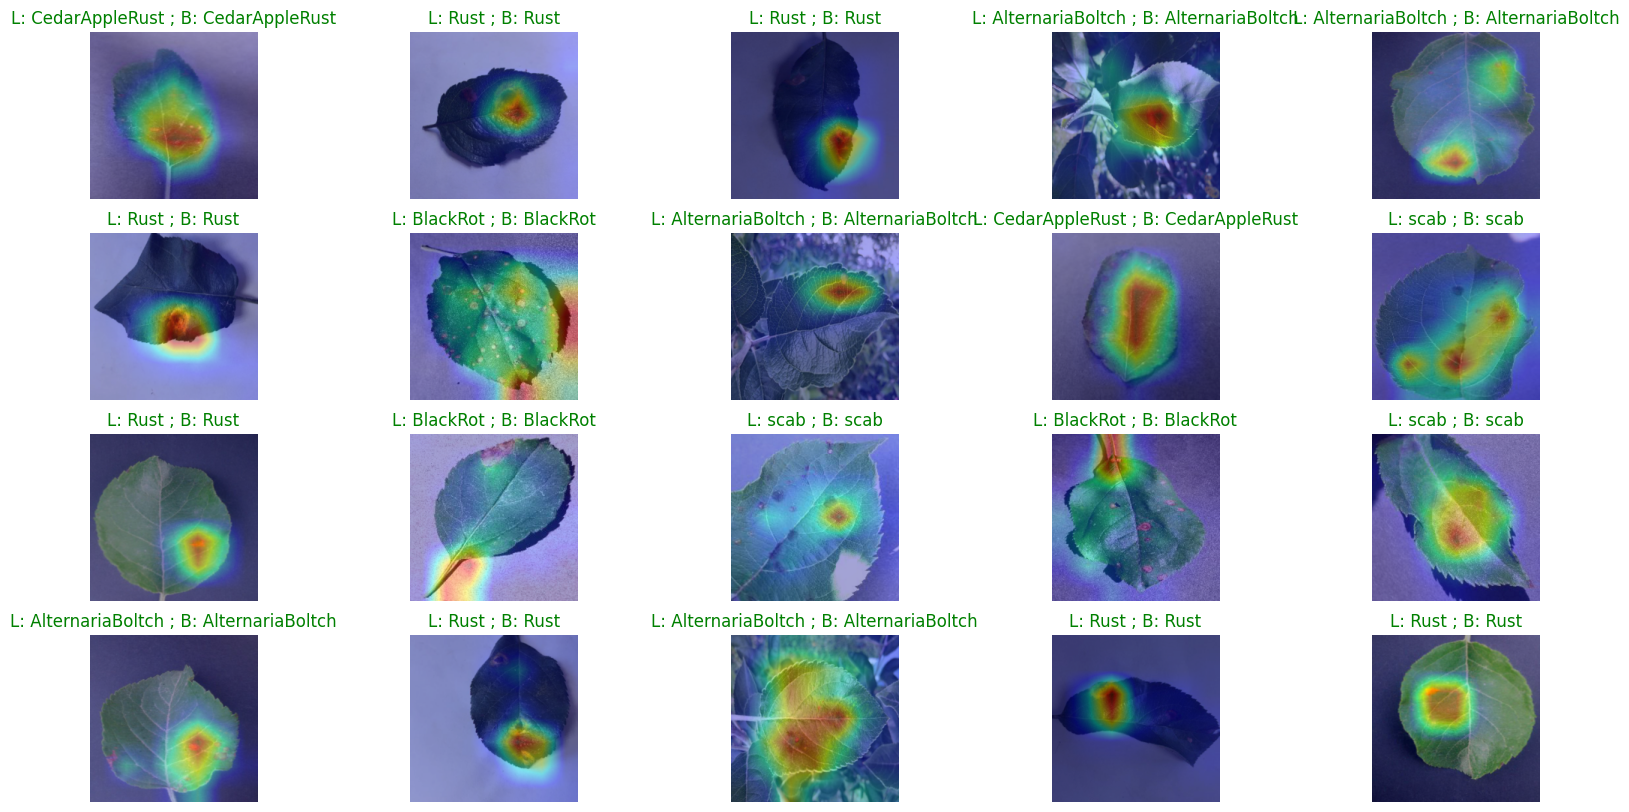

In [18]:
import cv2
import random
from utils import tensor_2_im
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

def inference_with_gradcam(model, device, test_dataloader, num_imgs, row, img_size = None, class_names = None):
    
    correct = 0
    all_predictions, all_images, all_labels = [], [], []
    
    for idx, batch in enumerate(test_dataloader):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        predictions = torch.argmax(model(images),dim=1)
        accuracy = (predictions == labels).sum().item()
        correct += accuracy
        all_images.append(images)
        all_labels.append(labels)
        all_predictions.append(predictions)

    print(f"{len(test_dataloader.dataset)} rasm test qilinganda {(correct * 100)/len(test_dataloader.dataset):.2f} % foiz aniqlikda topdi")

    plt.figure(figsize = (20, 10))
    #get random index between 0 and len(test_dataloder size) for plotting
    indexs = [random.randint(0, len(test_dataloader.dataset)-1) for _ in range(num_imgs)]
    for i, index in enumerate(indexs):
        
        img = all_images[index].squeeze() #extract random index image
        lb = all_labels[index]; pd = all_predictions[index]
    
        #GRADCAM tensorlar bn emas arraylar (CPU) bn ishlaydi 
        org_img = tensor_2_im(img) / 255  #Normalize np image into between [0, 1]
        #GradCamPlusPlus classidan obyekt olib unga model va oxirgi fc layerslarni jo'natamiz
        # cam = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]]) #for rexnet_150
        cam = GradCAMPlusPlus(model=model, target_layers=[model.layer4[-1]])
        #cam obyektiga 4D rasm jonatib keyin uni grayscalega convert qilib olamiz. 
        grayscale_cam = cam(input_tensor = img.unsqueeze(0))[0, :]
                                                                    #image-weight - heatmap mask opacity control
        heatmap = show_cam_on_image(img = org_img, mask=grayscale_cam, image_weight=0.1, use_rgb=True)
        
        #Start plot 
        plt.subplot(row, num_imgs // row, i + 1)
        plt.imshow(tensor_2_im(img), cmap = "gray"); plt.axis('off')
        resized_heatmap = cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_AREA)
        plt.imshow(resized_heatmap, alpha=0.4, cmap='jet'); plt.axis('off')

        color = ("green" if {class_names[lb]} == {class_names[pd]} else "red")
        if class_names: plt.title(f"L: {class_names[lb]} ; B: {class_names[pd]}", color = color)
        else: plt.title(f"L: {lb} ; B: {pd}")


model.load_state_dict(torch.load(f"{SAVE_DIR}/{SAVE_PREFIX}_best_model.pth"))
model.eval()
inference_with_gradcam(model=model, device=DEVICE, test_dataloader=test_dataloader, 
                       num_imgs=20, row=4, img_size = 224, class_names=class_names)



# TEST NEW IMAGE

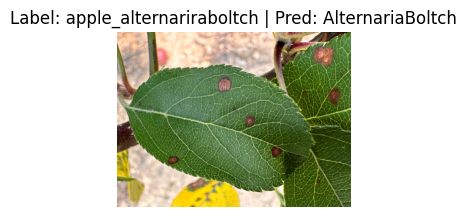

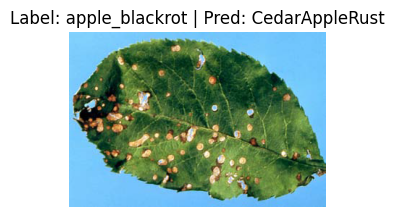

In [19]:
test_image_paths = ["data/test_images/apple_alternariraboltch.jpg", "data/test_images/apple_blackrot.png"]
model.load_state_dict(torch.load(f"{SAVE_DIR}/{SAVE_PREFIX}_best_model.pth"))

for i, im_path in enumerate(test_image_paths):
    test_img = Image.open(im_path).convert('RGB')
    tensor_img = tfs(test_img).to(DEVICE)
    img_name = im_path.split("/")[-1].split(".")[0]
    ###BASHORAT 
    bashorat = model(tensor_img.unsqueeze(dim=0))
    prediction = torch.argmax(bashorat, dim=1)
  
    plt.figure(figsize = (10 , 5))
    plt.subplot(2,2,i+1)
    plt.axis('off')
    plt.title(f"Label: {img_name} | Pred: {class_names[prediction.item()]}")
    plt.imshow(test_img)
    plt.show()

